In [44]:

!pip install lime
import os
import zipfile
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [49]:
# Brain Tumor Detection with CNN and LIME
# Step 1: Extract dataset
zip_path = 'archive.zip'  # Update with your zip file path
extract_path = "./dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
extract_path

'./dataset'

In [19]:
# Step 2: Select 1000 images per class
base_dir = extract_path  # The dataset root directory
yes_dir = os.path.join(base_dir, "yes")
no_dir = os.path.join(base_dir, "no")



selected_yes_dir = os.path.join(base_dir, "selected_train/yes")
selected_no_dir = os.path.join(base_dir, "selected_train/no")

os.makedirs(selected_yes_dir, exist_ok=True)
os.makedirs(selected_no_dir, exist_ok=True)

for img in os.listdir(yes_dir)[:1000]:
    shutil.copy(os.path.join(yes_dir, img), os.path.join(selected_yes_dir, img))
for img in os.listdir(no_dir)[:1000]:
    shutil.copy(os.path.join(no_dir, img), os.path.join(selected_no_dir, img))


In [41]:
# Step 3: Data Preprocessing & Augmentation
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = data_gen.flow_from_directory(
    os.path.join(base_dir, "selected_train"), target_size=(150, 150), batch_size=32, class_mode='binary', subset='training')
val_data = data_gen.flow_from_directory(
    os.path.join(base_dir, "selected_train"), target_size=(150, 150), batch_size=32, class_mode='binary', subset='validation')

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [51]:
# Step 4: Define CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,636,481 (40.57 MB)

 Trainable params: 10,636,481 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Step 5: Train the Model
epochs = 10
history = model.fit(train_data, validation_data=val_data, epochs=epochs)
model.save("brain_tumor_model.h5")


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9917 - loss: 0.0220 - val_accuracy: 0.9825 - val_loss: 0.0434
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9962 - loss: 0.0187 - val_accuracy: 0.9800 - val_loss: 0.0810
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9899 - loss: 0.0358 - val_accuracy: 0.9775 - val_loss: 0.1154
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9958 - loss: 0.0196 - val_accuracy: 0.9800 - val_loss: 0.0742
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9950 - loss: 0.0263 - val_accuracy: 0.9750 - val_loss: 0.0911
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9975 - loss: 0.0083 - val_accuracy: 0.9800 - val_loss: 0.0630
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9991 - loss: 0.0048 - val_accuracy: 0.9800 - val_loss: 0.0430
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9985 - loss: 0.0073 - val_accuracy: 0.9825 - val_loss:

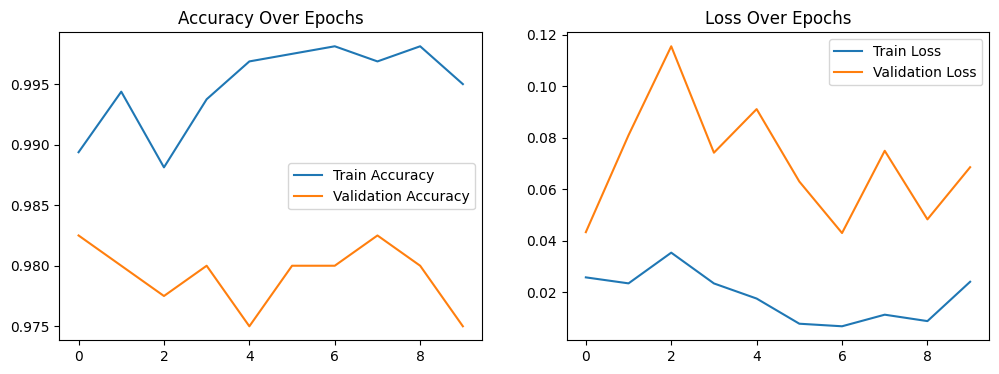

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 419ms/step


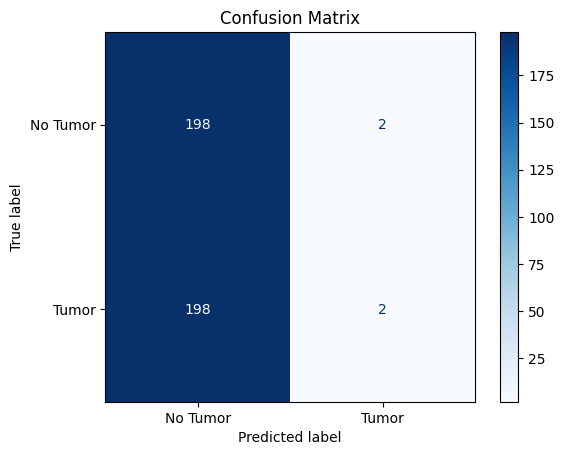

In [52]:
# Step 6: Model Evaluation
def plot_metrics(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title("Accuracy Over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title("Loss Over Epochs")
    plt.show()
plot_metrics(history)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true and predicted labels for validation set
val_labels = val_data.classes
val_preds = (model.predict(val_data) > 0.5).astype(int).flatten()

cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Tumor', 'Tumor'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [50]:
def predict_sample_image(model, img_path):
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)[0][0]
    final_prediction = "Tumor Detected" if prediction > 0.5 else "No Tumor Detected"
    print(f"Raw Prediction Output: {prediction}")
    print(f"Final Prediction: {final_prediction}")
    return final_prediction  # <- Add return statement


In [26]:
sample_img = "sampleimage.png"  # Replace with actual image path
final_prediction = predict_sample_image(model, sample_img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Raw Prediction Output: 0.0025130289141088724
Final Prediction: No Tumor Detected


In [27]:
def explain_lime(model, img_path, prediction_result):
    explainer = lime_image.LimeImageExplainer()

    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    def model_predict(images):
        preds = model.predict(np.array(images))
        return np.hstack([1 - preds, preds])  # Ensure [No Tumor, Tumor] probabilities

    print("Running LIME explanation...")
    explanation = explainer.explain_instance(img_array[0], model_predict, top_labels=2, hide_color=0, num_samples=1000)

    print(f"LIME Top Labels: {explanation.top_labels}")

    # Always use LIME's top label
    predicted_label = explanation.top_labels[0]

    # Generate LIME heatmap
    temp, mask = explanation.get_image_and_mask(predicted_label, positive_only=True, num_features=5, hide_rest=False)

    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(temp, mask))
    label_text = "Tumor Detected" if predicted_label == 1 else "No Tumor Detected"
    plt.title(f"LIME Explanation - {label_text}")
    plt.show()


Running LIME explanation...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

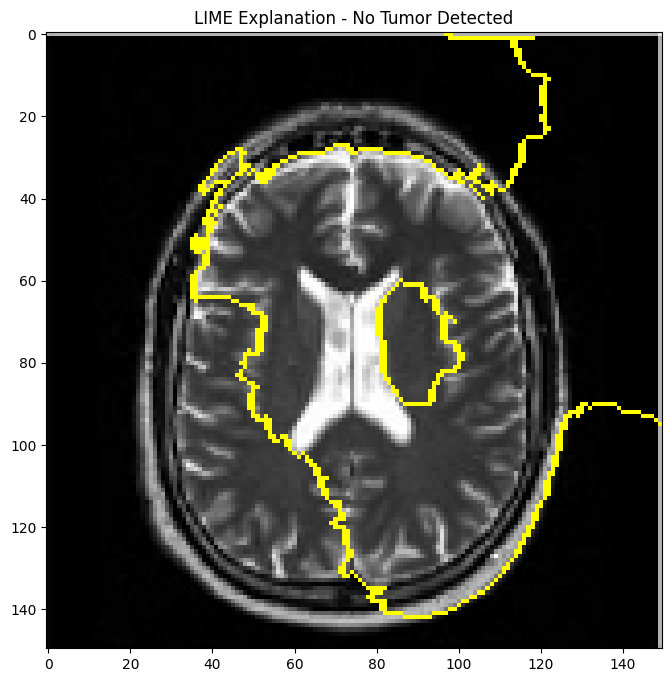

In [28]:
# Run LIME on a sample image
# Run LIME on a sample image
explain_lime(model, sample_img, final_prediction)

In [53]:
# Print Evaluation Metrics
print("Final Model Evaluation:")
eval_result = model.evaluate(val_data)
print(f"Validation Loss: {eval_result[0]:.4f}, Validation Accuracy: {eval_result[1]:.4f}")


Final Model Evaluation:
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 418ms/step - accuracy: 0.5127 - loss: 0.6942
Validation Loss: 0.6944, Validation Accuracy: 0.5050


In [55]:
model.save("brain_tumor_model.keras")